# Building Mouth Openness Detection Model using dlib for feature extractor:

## *Mouth Open-ness Detection Block:*

    This block is responsible for detection if the input face's mouth is open or not.
    
    Inputs: Person face.
                                    
    Outputs: This person face's mouth is open (1) or close (0)
            OR as a probability of open-ness between (0:1) 1 is open and 0 is close. 
    


In [7]:
import glob
import sys
import os
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm ,metrics
import pickle

%matplotlib inline

development = True

# A Machine Learning (ML) project is divided into many stages:

## 1. Gathering Data (Data Acquisition):

The first real step of machine learning is gathering data. This step is very important because the **quality and quantity** of data that you gather will directly determine how good your predictive model can be.

We define placeholders for the data as follows: 
* **x_train:** This represents the images in the training set. 
* **y_train:** This represents the labels of the images in the training set.  

In [8]:
classification = ['closed' , 'opened']
x_train = []
y_train = []
x_test = []
y_test = []

In [9]:
# load dataset:
DataSetDir="C:/Collage/GP/My_Social_Eye/speaker_detection/dataset_formation/"
###############################################################################

# load open mouth images:
for filename in sorted(glob.glob(DataSetDir+'open_mouth/*.jpg')):
    img = cv2.imread(filename) ## cv2.imread reads images in RGB format
    x_train.append(img)
    y_train.append(1) # 1 for open mouth 
# load open mouth images for test:
for filename in sorted(glob.glob(DataSetDir+'open_mouth_test/*.jpg')):
    img = cv2.imread(filename) ## cv2.imread reads images in RGB format
    x_test.append(img)
    y_test.append(1) # 1 for open mouth

###############################################################################

# load close mouth images:
for filename in sorted(glob.glob(DataSetDir+'close_mouth/*.jpg')):
    img = cv2.imread(filename) ## cv2.imread reads images in RGB format
    x_train.append(img)
    y_train.append(0) # 0 for close mouth

# load open mouth images for test:
for filename in sorted(glob.glob(DataSetDir+'close_mouth_test/*.jpg')):
    img = cv2.imread(filename) ## cv2.imread reads images in RGB format
    x_test.append(img)
    y_test.append(0) # 0 for close mouth

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print ("The size of the training set is: ", x_train.shape)
print ("The size of the labels of the training set is: ", y_train.shape)

x_test = np.array(x_test)
y_test = np.array(y_test)
print ("The size of the test set is: ", x_test.shape)
print ("The size of the labels of the test set is: ", y_test.shape)


The size of the training set is:  (17342, 288, 360, 3)
The size of the labels of the training set is:  (17342,)
The size of the test set is:  (137, 288, 360, 3)
The size of the labels of the test set is:  (137,)


We will now visualize this dataset. 

**Note: You can run the following cell multiple times to view different shapes in the dataset as well as the ground-truth value associated with this training image.**

The ground-truth value of this image is:  opened


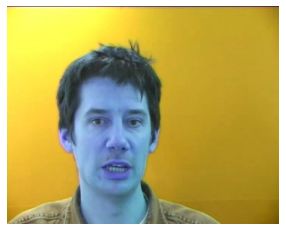

In [11]:
# Generate a random index from 0 to 100 inclusive. 
random_index = np.random.randint(0,100)

# Plot the image.
plt.imshow(x_train[random_index],cmap='gray')
plt.axis("off")

print("The ground-truth value of this image is: " , classification[y_train[random_index]])

- - -
# 2. Data Preprocessing:

The second stage is to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis. We need to prepare it to be suitable for our problem.

We will ignore this stage in our dlib implementation..

- - -
# 3. Feature Extraction: 

Now that we have clean and preprocessed data, we can use it to solve our classification problem.

This step could be either:
    
* **Feature Engineering:** transformation of raw data into features suitable for modeling.

* **Feature Transformation:** transformation of data to improve the accuracy of the algorithm.

* **Feature Selection:** removing unnecessary features.
    
The process of feature extraction in our problem can have many designs:

* One design is to extract the number of black pixels compared to the number of white pixels in each image and use this feature to differentiate between different shapes. (Is this a powerful feature?) Can you think of other features?

But we have to think for a better approach so ..
### We will be using the distance between the lips as our feature!

In [12]:
predictor_path = "C:/Collage/GP/My_Social_Eye/speaker_detection/face_landmarks/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)

# for development only
detector = dlib.get_frontal_face_detector()

In [16]:
# using the distance between the lips as our feature!
def getLipsDistance(face):
    # to be remove when integration is done:
    if development:
        dets = detector(face, 1)
    feats = []
    for _, d in enumerate(dets):
        shape = predictor(face, d)

        upper1 = np.asarray([shape.part(61).x, shape.part(61).y])
        upper2 = np.asarray([shape.part(62).x, shape.part(62).y])
        upper3 = np.asarray([shape.part(63).x, shape.part(63).y])
        lower1 = np.asarray([shape.part(67).x, shape.part(67).y])
        lower2 = np.asarray([shape.part(66).x, shape.part(66).y])
        lower3 = np.asarray([shape.part(65).x, shape.part(65).y])

        feat = (np.linalg.norm(upper1-lower1) +
                np.linalg.norm(upper2-lower2)+np.linalg.norm(upper3-lower3))/3
        feats.append(feat)
    return np.array(feats)


In [18]:
train_features = []
train_y = []
for ind in range(x_train.shape[0]):
    lipDist = getLipsDistance(x_train[ind])
    if lipDist.shape[0] > 0:
        train_features.append(lipDist)
        train_y.append(y_train[ind])
train_features= np.array(train_features)
train_y = np.array(train_y)

We finally populate the array **train_features** with the extracted features from each image using the functions you implemented earlier. 

In [19]:
print(train_features.shape)

print(train_features[0:10])
print(train_y[0:10])

(17339, 1)
[[10.66666667]
 [ 9.33333333]
 [ 9.33333333]
 [10.        ]
 [10.03325041]
 [ 9.        ]
 [10.33333333]
 [ 9.33333333]
 [11.01512034]
 [10.        ]]
[1 1 1 1 1 1 1 1 1 1]


- - -
# 4. ML Model: 
It’s time to feed the crafted features to the classification algorithm that is going to classify or predict the class of unknown or newly unseen data (called testing data). The process of choosing which classification algorithm will yield the best results is not an easy one. It is often subject to many iterations of tuning parameters and features.

In this block, we will apply **SVM** as our classification algorithm.

In [77]:
#SVM CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].
def svmCLF(feats,y_lbl,test_x,test_y):
    #clf = svm.SVC(kernel='poly',degree=3,gamma=0.001,C=100) 
    #clf = svm.SVC(kernel='rbf',gamma=0.001,C=100)
    clf = svm.SVC(kernel='linear',C=100 , probability=True)
    #clf = svm.SVC(kernel='sigmoid',gamma=0.001,C=100)
    
    clf.fit(feats, y_lbl)
    y_preds = clf.predict(test_x)
        
    ascore = metrics.accuracy_score(test_y, y_preds)
    pscore = metrics.precision_score(test_y, y_preds,average='weighted')
    rscore = metrics.recall_score(test_y, y_preds,average='weighted')
    fscore = metrics.f1_score(test_y, y_preds,average='weighted')
    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return clf

x_test_feat = [getLipsDistance(x) for x in x_test]
x_test_feat= np.array(x_test_feat)
print(x_test_feat.shape)
svm_clf = svmCLF(train_features,train_y,x_test_feat,y_test)

(137, 1)
Accuracy: 100.0 %
Precision: 100.0 %
Recall: 100.0 %
f1 score: 100.0 %


In [85]:
# test on a random feature:
sample_feature = np.array([3.2]).reshape(-1,1)  
sample_pred = svm_clf.predict_proba(sample_feature)
print(sample_pred[0][1])

###############################################################################
#####################    SVM CLASSIFIER END     ###############################
###############################################################################
##################### rbf kernel:               ###############################
##################### threshold at 3.2          ###############################
#####################                           ###############################
##################### poly kernel:              ###############################
##################### threshold at 4.5          ###############################
#####################                           ###############################
##################### sigmoid kernel:           ###############################
##################### threshold at 3.2          ###############################
#####################                           ###############################
##################### linear kernel:            ###############################
##################### threshold at 3.0          ###############################
###############################################################################


0.5436220352568636


In [82]:
filename = 'dlib_model.sav'
pickle.dump(svm_clf, open(filename, 'wb'))